### Getting the data

In [1]:
import os
os.chdir('..')

In [2]:
# Uncomment to download mini-sample dataset
# !mkdir data/mini_sample -p
# !gsutil -m -q cp -r 'gs://deepfwi-mini-sample/*' data/mini_sample

### Running the inference and the benchmark

In [3]:
from src.test import run

Providing the configuration options,

In [4]:
config = dict(
    in_days=2,
    out_days=1,
    checkpoint_file="src/model/checkpoints/pre_trained/2_1/epoch_91_100.ckpt",
    reanalysis_dir="data/mini_sample/fwi-reanalysis",
    forcings_dir="data/mini_sample/fwi-forcings",
    forecast_dir="data/mini_sample/fwi-forecast",
)

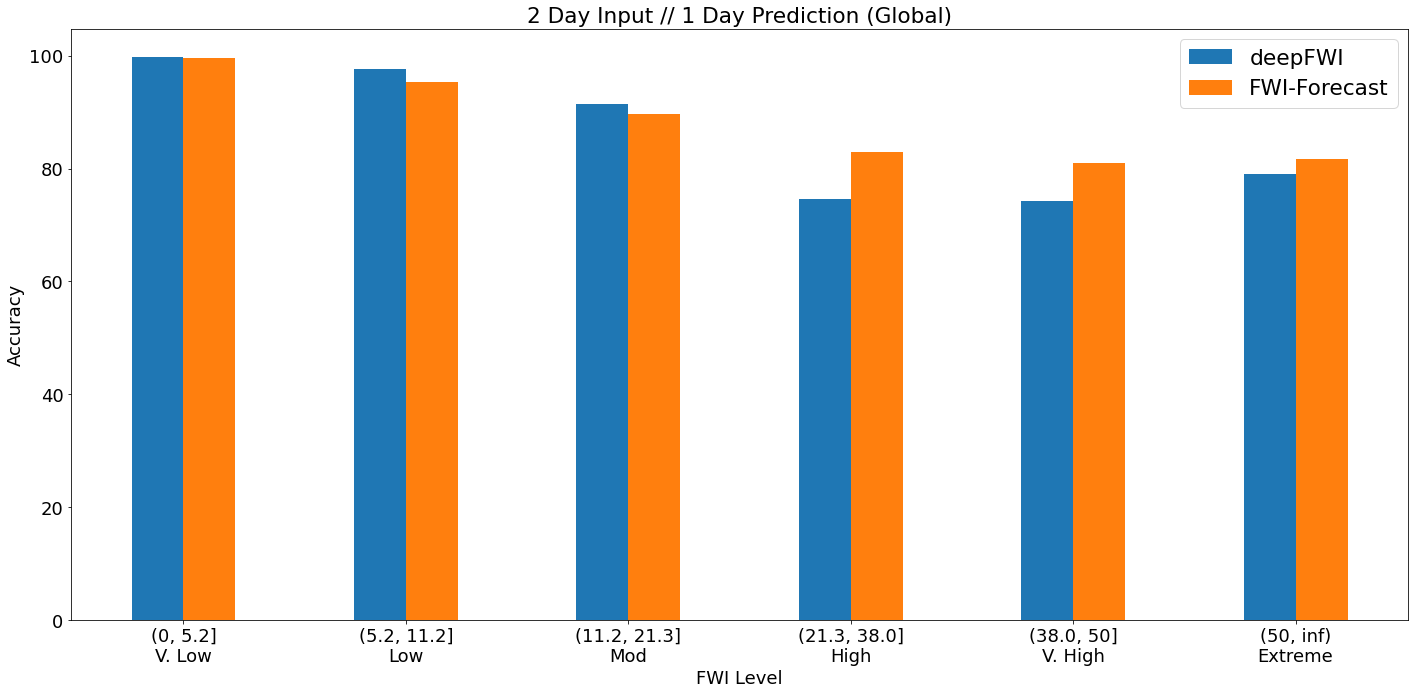

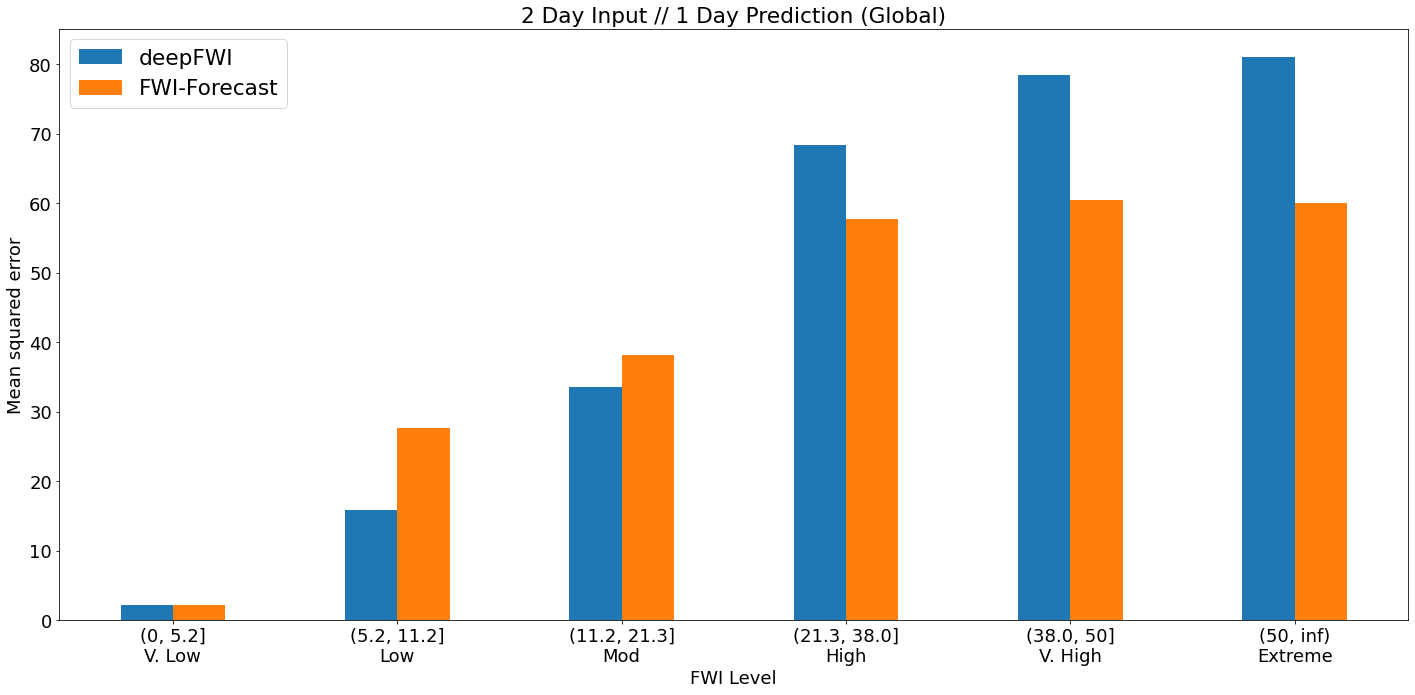

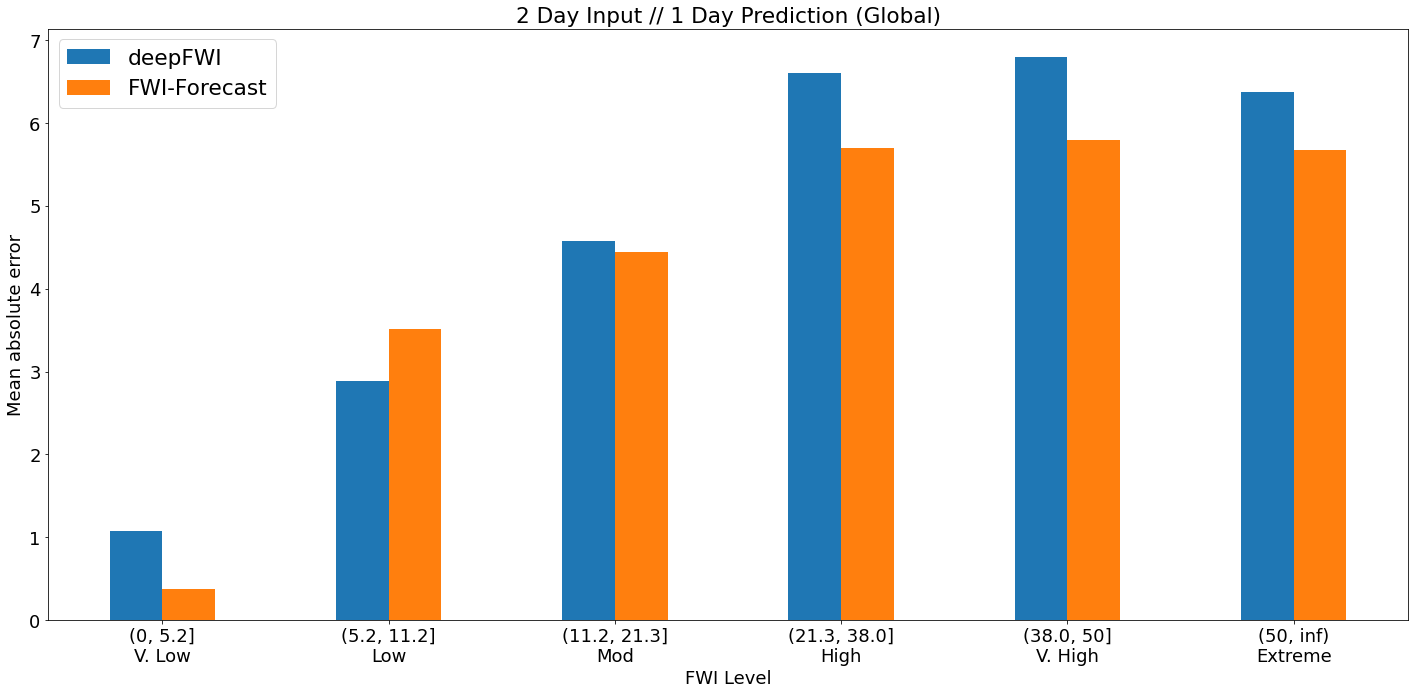

In [5]:
run(**config, benchmark=True);